Win Rate: 0.75
R-Ratio: 0.78
% Risk per Trade: 0.010
# of Simulations: 10000
# of Trades: 240.00
Risk-Free Rate: 5.50%
Trades per Month: 20


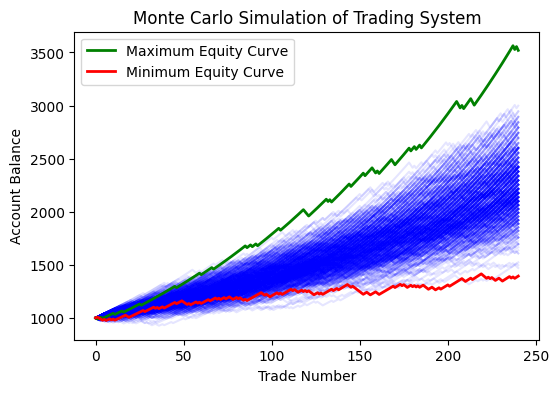

Starting Balance: 1000.00
Mean Final Balance: 2229.57
Standard Deviation: 269.30
Minimum Final Balance: 1393.52
Maximum Final Balance: 3519.59
Maximum Drawdown of Worst Case: 0.14
Mean Maximum Drawdown: 0.04
99th Percentile Drawdown: 0.08
Max Consecutive Wins: 46
Max Consecutive Losses: 11
% of accounts underwater: % 0.00
Sharpe Ratio: 6.08
Sortino Ratio: 16.96


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import random

def calculate_drawdown(balances):
    peak = balances[0]
    drawdowns = []
    for balance in balances:
        if balance > peak:
            peak = balance
        drawdown = (peak - balance) / peak
        drawdowns.append(drawdown)
    return drawdowns

def calculate_sharpe_ratio(returns, risk_free_rate):
    excess_returns = returns - risk_free_rate / 12  # Monthly risk-free rate
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns)
    return sharpe_ratio * np.sqrt(12)  # Annualize the Sharpe ratio

def calculate_sortino_ratio(returns, risk_free_rate):
    excess_returns = returns - risk_free_rate / 12  # Monthly risk-free rate
    downside_returns = excess_returns[excess_returns < 0]
    if len(downside_returns) == 0:
        return np.nan  # If no downside returns, Sortino ratio is not defined
    downside_deviation = np.std(downside_returns)
    sortino_ratio = np.mean(excess_returns) / downside_deviation
    return sortino_ratio * np.sqrt(12)  # Annualize the Sortino ratio

def monte_carlo_simulation(win_rate, reward_to_risk, risk_per_trade, num_simulations, num_trades, trades_per_month, risk_free_rate):
    all_balances = []
    final_balances = []
    max_drawdowns = []
    all_monthly_returns = []
    max_consecutive_wins = []
    max_consecutive_losses = []
    total_numof_account_underwater = 0

    start_balance = 1000

    for _ in range(num_simulations):
        balance = start_balance
        balances = [balance]
        monthly_returns = []
        consecutive_wins = 0
        consecutive_losses = 0
        max_wins = 0
        max_losses = 0
        
        for trade in range(1, num_trades + 1):
            if np.random.rand() <= win_rate:
                # Win trade
                balance += balance * risk_per_trade * reward_to_risk
                consecutive_wins += 1
                consecutive_losses = 0
            else:
                # Lose trade
                balance -= balance * risk_per_trade
                consecutive_losses += 1
                consecutive_wins = 0

            # Update max consecutive wins and losses
            if consecutive_wins > max_wins:
                max_wins = consecutive_wins
            if consecutive_losses > max_losses:
                max_losses = consecutive_losses

            if trade % trades_per_month == 0:  # Aggregate returns every trades_per_month trades
                monthly_return = balance / balances[-trades_per_month] - 1 if len(balances) >= trades_per_month else balance / start_balance - 1
                monthly_returns.append(monthly_return)

            balances.append(balance)

        if balance < start_balance:
            total_numof_account_underwater += 1
        
        all_balances.append(balances)
        final_balances.append(balance)
        max_drawdowns.append(max(calculate_drawdown(balances)))
        all_monthly_returns.append(monthly_returns)
        max_consecutive_wins.append(max_wins)
        max_consecutive_losses.append(max_losses)

    # Select 1000 random simulations for plotting
    random_indices = random.sample(range(num_simulations), min(500, num_simulations))

    # Plot the results
    plt.figure(figsize=(6, 4))
    for idx in random_indices:
        plt.plot(all_balances[idx], color='blue', alpha=0.1)
    
    plt.plot(all_balances[np.argmax(final_balances)], color='green', linewidth=2, label='Maximum Equity Curve')
    plt.plot(all_balances[np.argmin(final_balances)], color='red', linewidth=2, label='Minimum Equity Curve')
    plt.title('Monte Carlo Simulation of Trading System')
    plt.xlabel('Trade Number')
    plt.ylabel('Account Balance')
    plt.legend()
    plt.show()

    # Statistical summary of final balances and drawdowns
    max_drawdown_worst_case = max(max_drawdowns)
    mean_drawdown = np.mean(max_drawdowns)
    drawdown_99_percentile = np.percentile(max_drawdowns, 99)
    
    print(f'Starting Balance: {start_balance:.2f}')
    print(f'Mean Final Balance: {np.mean(final_balances):.2f}')
    print(f'Standard Deviation: {np.std(final_balances):.2f}')
    print(f'Minimum Final Balance: {np.min(final_balances):.2f}')
    print(f'Maximum Final Balance: {np.max(final_balances):.2f}')
    print(f'Maximum Drawdown of Worst Case: {max_drawdown_worst_case:.2f}')
    print(f'Mean Maximum Drawdown: {mean_drawdown:.2f}')
    print(f'99th Percentile Drawdown: {drawdown_99_percentile:.2f}')
    print(f'Max Consecutive Wins: {np.max(max_consecutive_wins)}')
    print(f'Max Consecutive Losses: {np.max(max_consecutive_losses)}')
    print(f'% of accounts underwater: % {(total_numof_account_underwater/num_simulations*100):.2f}')

    # Flatten all monthly returns to calculate Sharpe and Sortino ratios
    all_monthly_returns_flat = np.concatenate(all_monthly_returns)
    
    sharpe_ratio = calculate_sharpe_ratio(all_monthly_returns_flat, risk_free_rate)
    sortino_ratio = calculate_sortino_ratio(all_monthly_returns_flat, risk_free_rate)
    
    print(f'Sharpe Ratio: {sharpe_ratio:.2f}')
    print(f'Sortino Ratio: {sortino_ratio:.2f}')

# Example usage
win_rate = 0.75  # put win rate here
reward_to_risk = 845.25/1084  # Reward to risk ratio 
risk_per_trade = 0.01  # Risking % of the trade
num_simulations = 10000  # Run X number of simulations
trades_per_month = 20  # Number of trades per month
num_trades = 12*trades_per_month*1  # Each simulation runs for X trades

risk_free_rate = 0.055  # Annual risk-free rate

print(f'Win Rate: {win_rate:.2f}')
print(f'R-Ratio: {reward_to_risk:.2f}')
print(f'% Risk per Trade: {risk_per_trade:.3f}')
print(f'# of Simulations: {num_simulations:.0f}')
print(f'# of Trades: {num_trades:.2f}')
print(f'Risk-Free Rate: {risk_free_rate:.2%}')
print(f'Trades per Month: {trades_per_month}')

monte_carlo_simulation(win_rate, reward_to_risk, risk_per_trade, num_simulations, num_trades, trades_per_month, risk_free_rate)


In [6]:
balance=100
risk=0.02
trades=20
for i in range(0,trades):
    balance=balance-balance*risk
    print(balance)



98.0
96.04
94.1192
92.236816
90.39207968000001
88.5842380864
86.81255332467201
85.07630225817857
83.374776213015
81.7072806887547
80.0731350749796
78.47167237348002
76.90223892601041
75.36419414749021
73.8569102645404
72.37977205924959
70.9321766180646
69.51353308570332
68.12326242398925
66.76079717550947
